# **SEGMENTING DEFECTIVE, NON-DEFECTIVE STEEL & LOCALISING THE DEFECTS**

In [8]:
# importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from skimage import io
from sklearn.preprocessing import StandardScaler, normalize
import os
%matplotlib inline

In [9]:
# dataset containing defect images with segmentation mask 
defect_class_mask_df = pd.read_csv('/content/drive/MyDrive/ML Projects/Image-Segmentation-Model/train.csv')

# dataset containing defective and non defective images
all_images_df = pd.read_csv('/content/drive/MyDrive/ML Projects/Image-Segmentation-Model/defect_and_no_defect.csv')

In [ ]:
defect_class_mask_df
# in the below dataframe, "EncodedPixels" is the RunLengthEncoding of every image mask

,ImageId,ClassId,EncodedPixels
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...
...,...,...,...
5743,c12842f5e.jpg,3,88 23 342 29 596 34 850 39 1105 44 1361 46 161...
5744,2222a03b3.jpg,3,63332 4 63587 11 63841 20 64096 27 64351 35 64...
5745,b43ea2c01.jpg,1,185024 7 185279 11 185535 12 185790 13 186045 ...
5746,1bc37a6f4.jpg,3,303867 1 304122 3 304376 6 304613 3 304630 9 3...


In [ ]:
# contains both defectove & non-defective steel images
all_images_df

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1
...,...,...
12992,0482ee1d6.jpg,0
12993,04802a6c2.jpg,0
12994,03ae2bc91.jpg,0
12995,04238d7e3.jpg,0


## **Data Visualization**

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of images per class')

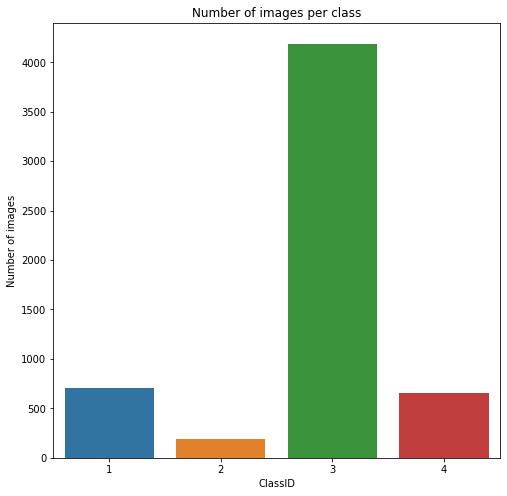

In [ ]:
plt.figure(figsize=(8,8))
sns.countplot(defect_class_mask_df['ClassId'])
plt.ylabel('Number of images')
plt.xlabel('ClassID')
plt.title('Number of images per class')

In [ ]:
print('Number of images per defect:')
print(defect_class_mask_df['ClassId'].value_counts())

Number of images per defect:
3    4188
1     710
4     655
2     195
Name: ClassId, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of images per label')

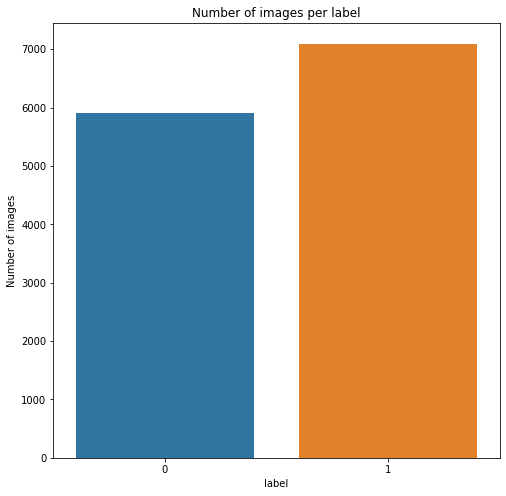

In [ ]:
plt.figure(figsize=(8,8))
sns.countplot(all_images_df['label'])
plt.ylabel('Number of images')
plt.xlabel('label')
plt.title('Number of images per label')

In [ ]:
print('Number of images per label')
print(all_images_df['label'].value_counts())

Number of images per label
1    7095
0    5902
Name: label, dtype: int64


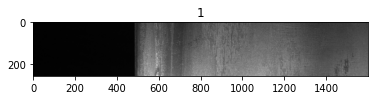

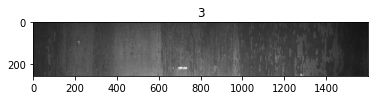

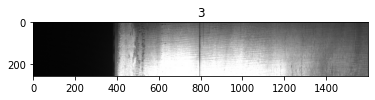

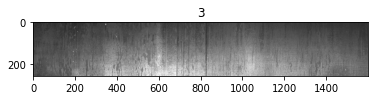

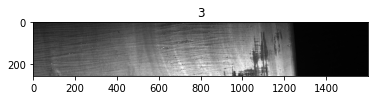

In [10]:
train_img_dir = '/content/drive/MyDrive/ML Projects/Image-Segmentation-Model/train_images'

for i in range(5):
  img = io.imread(os.path.join(train_img_dir, defect_class_mask_df['ImageId'][i]))
  plt.figure()
  plt.title(defect_class_mask_df.ClassId[i])
  plt.imshow(img)

In [11]:
%cd /content/drive/MyDrive/ML Projects/Image-Segmentation-Model
from utilities import rle2mask , mask2rle

/content/drive/MyDrive/ML Projects/Image-Segmentation-Model


In [ ]:
image_index = 15 #for example
mask = rle2mask(defect_class_mask_df['EncodedPixels'][image_index], img.shape[0], img.shape[1])

mask.shape

(256, 1600)

Text(0.5, 1.0, 'Mask Image')

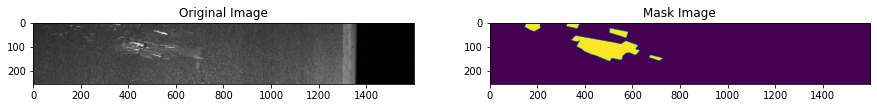

In [ ]:
# comparing originl image and its mask
img = io.imread(os.path.join(train_img_dir, defect_class_mask_df['ImageId'][image_index]))

plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title('Mask Image')

# In the below plot, yellow region indicates the defect

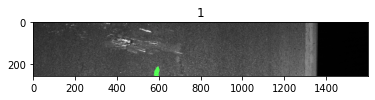

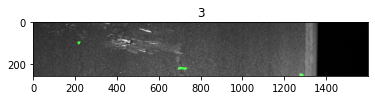

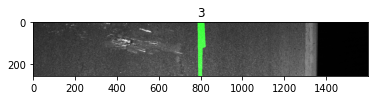

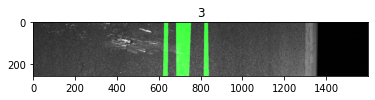

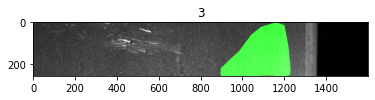

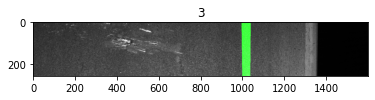

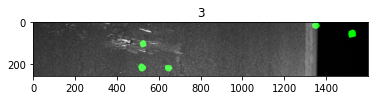

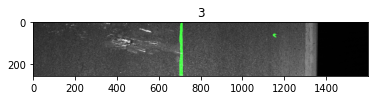

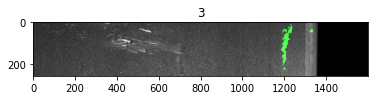

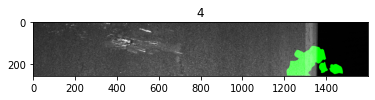

In [ ]:
for i in range(10):

  img = io.imread(os.path.join(train_img_dir, defect_class_mask_df['ImageId'][image_index]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  mask = rle2mask(defect_class_mask_df['EncodedPixels'][i], img.shape[0], img.shape[1])

  # coloring pixels with value 1
  img[mask == 1,1] = 255
  plt.figure()
  plt.imshow(img)
  plt.title(defect_class_mask_df.ClassId[i])

## **Generating the Train & Test Dataset**

In [12]:
# creating training and test data
all_images_df['label'] = all_images_df['label'].astype(str)
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(all_images_df, test_size = 0.2, random_state=0)

print(train_df.shape[0])
print(test_df.shape[0])

10397
2600


In [13]:
# generating the Train & Validation image data
from keras.preprocessing.image import ImageDataGenerator

BS = 16
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

train_data = datagen.flow_from_dataframe(dataframe = train_df,
                                          directory = train_img_dir,
                                          x_col = "ImageID",
                                          y_col = "label",
                                          subset = "training",
                                          batch_size = BS,
                                          shuffle = True,
                                          class_mode = "binary",
                                          target_size = (256, 256))


valid_data = datagen.flow_from_dataframe(dataframe = train_df,
                                          directory = train_img_dir,
                                          x_col = "ImageID",
                                          y_col = "label",
                                          subset = "validation",
                                          batch_size = BS,
                                          shuffle = True,
                                          class_mode = "binary",
                                          target_size = (256, 256))

Found 8838 validated image filenames belonging to 2 classes.
Found 1559 validated image filenames belonging to 2 classes.


In [14]:
# generating the Test image data
test_datagen = ImageDataGenerator(rescale=1./255.)

test_data = test_datagen.flow_from_dataframe(dataframe = test_df,
                                              directory = train_img_dir,
                                              x_col = "ImageID",
                                              y_col = None,
                                              batch_size = 16,
                                              shuffle = False,
                                              class_mode = None,
                                              target_size = (256, 256))

Found 2600 validated image filenames.


## **Developing the Image segmentation & defect-localization model**

In [15]:
# importing the required libraries
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# peroforming transfer learning
basemodel = VGG19(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))

# freezing the layers of the base model to prevent the weights from getting changed
for layer in basemodel.layers:
  layer.trainable = False

basemodel.summary()

80142336/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
______________________________________________________________

In [ ]:
model = Sequential()
model.add(basemodel)
model.add(AveragePooling2D(pool_size = (4,4)))
model.add(Flatten(name= 'flatten'))
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='Adam', metrics=["accuracy"])

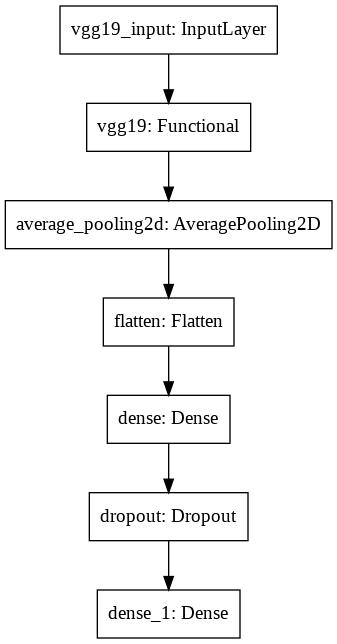

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, '/content/drive/MyDrive/ML Projects/Image-Segmentation-Model/model.jpg')

In [ ]:
# model training
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint(filepath="/content/drive/MyDrive/ML Projects/Image-Segmentation-Model/final_model_2.h5", verbose=1, save_best_only=True)
callbacks = [es, mc]

history = model.fit_generator(train_data, 
                              steps_per_epoch= train_data.n // train_data.batch_size, 
                              epochs = 100, 
                              validation_data= valid_data,  
                              validation_steps= valid_data.n // valid_data.batch_size, 
                              callbacks=callbacks) 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
552/552 [==============================] - 3896s 7s/step - loss: 0.5930 - accuracy: 0.6818 - val_loss: 0.5187 - val_accuracy: 0.7165

Epoch 00001: val_loss improved from inf to 0.51874, saving model to /content/drive/MyDrive/ML Projects/Image-Segmentation-Model/final_model_2.h5
Epoch 2/100
552/552 [==============================] - 99s 180ms/step - loss: 0.4669 - accuracy: 0.7647 - val_loss: 0.4467 - val_accuracy: 0.7829

Epoch 00002: val_loss improved from 0.51874 to 0.44672, saving model to /content/drive/MyDrive/ML Projects/Image-Segmentation-Model/final_model_2.h5
Epoch 3/100
552/552 [==============================] - 102s 185ms/step - loss: 0.4383 - accuracy: 0.7962 - val_loss: 0.4279 - val_accuracy: 0.8086

Epoch 00003: val_loss improved from 0.44672 to 0.42793, saving model to /content/drive/MyDrive/ML Projects/Image-Segmentation-Model/final_model_2.h5
Epoch 4/100
552/552 [==============================] - 104s 189ms/step - loss: 0.4090 - accuracy: 0.8044 - val_loss:

## **loss: 0.2059 - accuracy: 0.9102 - val_loss: 0.2480 - val_accuracy: 0.9046**

In [16]:
# loading the trained model
model = load_model('/content/drive/MyDrive/ML Projects/Image-Segmentation-Model/final_model.h5') 

In [20]:
test_predictions = model.predict(test_data, steps=test_data.n // test_data.batch_size, verbose=1)
test_predictions

162/162 [==============================] - 1826s 11s/step


array([[8.5095364e-01],
       [9.0918756e-01],
       [6.9321871e-01],
       ...,
       [9.8397911e-01],
       [6.4879187e-15],
       [1.9489123e-01]], dtype=float32)

In [ ]:
predict = []
for prediction in test_predictions:
  if prediction < 0.6: 
    predict.append(0)
  else:
    predict.append(1)

predict = np.asarray(predict)
predict

array([1, 1, 1, ..., 1, 0, 0])

In [ ]:
len(predict)

2592

In [ ]:
test_df['label'] = test_df['label'].astype(int)
original = np.asarray(test_df.label)[:2592]
len(original)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


2592

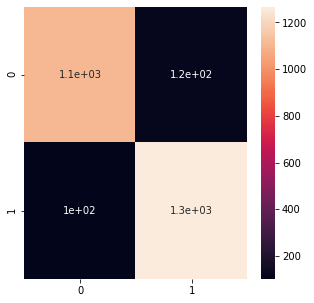

In [ ]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True)

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(original, predict)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1224
           1       0.92      0.93      0.92      1368

    accuracy                           0.92      2592
   macro avg       0.92      0.91      0.92      2592
weighted avg       0.92      0.92      0.92      2592



## **Image Segmentation**

In [21]:
# splitting the dataset conataining only the images with defect
X_train, X_val = train_test_split(defect_class_mask_df, test_size=0.2)

In [22]:
train_ids = list(X_train.ImageId)
train_class = list(X_train.ClassId)
train_rle = list(X_train.EncodedPixels)

val_ids = list(X_val.ImageId)
val_class = list(X_val.ClassId)
val_rle = list(X_val.EncodedPixels)

In [23]:
%cd /content/drive/MyDrive/ML Projects/Image-Segmentation-Model
from utilities import DataGenerator

#creating image generators
training_generator = DataGenerator(train_ids, train_class, train_rle, train_img_dir)
validation_generator = DataGenerator(val_ids, val_class,val_rle, train_img_dir)

/content/drive/MyDrive/ML Projects/Image-Segmentation-Model


In [24]:
# defining the residual block for the ResUnet model

def resblock(X, f):

  # making a copy of input
  X_copy = X

  # main path
  X = Conv2D(f, kernel_size = (1,1), strides = (1,1), kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output of the main path and short path 
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [25]:
# function to upscale and concatnating the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [26]:
input_shape = (256,256,1)

#Input tensor shape
X_input = Input(input_shape)

#Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

#Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

#Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

#Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

#Stage 5
conv5_in = resblock(pool_4, 256)

#Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

#Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

#Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

#Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

#Final Output
output = Conv2D(4, (1,1), padding = "same", activation = "sigmoid")(up_4)

# segmentation model
model_seg = Model(inputs = X_input, outputs = output)


In [17]:
%cd /content/drive/MyDrive/ML Projects/Image-Segmentation-Model
import utilities
from utilities import focal_tversky, tversky_loss, tversky

/content/drive/MyDrive/ML Projects/Image-Segmentation-Model


In [28]:
import tensorflow as tf

adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky,  metrics = [tversky])

In [29]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint(filepath="/content/drive/MyDrive/ML Projects/Image-Segmentation-Model/final_segmentation_model.h5", verbose=1, save_best_only=True)

callback = [es, mc]

In [30]:
history = model_seg.fit_generator(training_generator, 
                                  epochs=40, 
                                  validation_data=validation_generator, 
                                  callbacks=callback)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
287/287 [==============================] - 3535s 12s/step - loss: 0.9634 - tversky: 0.0484 - val_loss: 0.9259 - val_tversky: 0.0974

Epoch 00001: val_loss improved from inf to 0.92591, saving model to /content/drive/MyDrive/ML Projects/Image-Segmentation-Model/final_segmentation_model.h5
Epoch 2/40
287/287 [==============================] - 120s 418ms/step - loss: 0.8635 - tversky: 0.1760 - val_loss: 0.7500 - val_tversky: 0.3163

Epoch 00002: val_loss improved from 0.92591 to 0.74996, saving model to /content/drive/MyDrive/ML Projects/Image-Segmentation-Model/final_segmentation_model.h5
Epoch 3/40
287/287 [==============================] - 109s 378ms/step - loss: 0.6856 - tversky: 0.3930 - val_loss: 0.6567 - val_tversky: 0.4263

Epoch 00003: val_loss improved from 0.74996 to 0.65670, saving model to /content/drive/MyDrive/ML Projects/Image-Segmentation-Model/final_segmentation_model.h5
Epoch 4/40
287/287 [==============================] - 109s 379ms/step - loss: 0.6564 - tve

In [18]:
#loading the trained model
model_seg = load_model('/content/drive/MyDrive/ML Projects/Image-Segmentation-Model/final_segmentation_model.h5', 
                       custom_objects={'focal_tversky': focal_tversky, 'tversky': tversky})

In [19]:
# data containing test images for segmentation task 
test_df = pd.read_csv('test.csv')

In [20]:
test_df

,ImageId,ClassId,EncodedPixels
0,0ca915b9f.jpg,3,188383 3 188637 5 188892 6 189148 5 189403 6 1...
1,7773445b7.jpg,3,75789 33 76045 97 76300 135 76556 143 76811 15...
2,5e0744d4b.jpg,3,120323 91 120579 182 120835 181 121091 181 121...
3,6ccde604d.jpg,3,295905 32 296098 95 296290 159 296483 222 2967...
4,16aabaf79.jpg,1,352959 24 353211 28 353465 31 353719 33 353973...
...,...,...,...
633,a4334d7da.jpg,4,11829 7 12073 20 12317 32 12566 40 12821 41 13...
634,418e47222.jpg,3,46340 43 46596 127 46852 211 47108 253 47364 2...
635,817a545aa.jpg,3,206529 64 206657 4518 211201 179 211457 128 21...
636,caad490a5.jpg,3,59631 10 59867 30 60103 50 60339 69 60585 79 6...


In [23]:
from utilities import prediction

# make prediction
image_id, defect_type, mask = prediction(test_df, model, model_seg)

In [24]:
# create a dataframe for the result
df_pred = pd.DataFrame({'ImageId': image_id,'EncodedPixels': mask,'ClassId': defect_type})
df_pred.head()

,ImageId,EncodedPixels,ClassId
0,0ca915b9f.jpg,199372 6 199383 2 199628 6 199639 2 199884 6 1...,3
1,7773445b7.jpg,4143 1 4399 1 4655 1 4911 1 5167 1 5423 1 5677...,3
2,5e0744d4b.jpg,53645 10 53656 3 53663 2 53901 10 53912 3 5391...,3
3,6ccde604d.jpg,287235 4 287491 4 287747 4 288003 4 288259 4 2...,3
4,16aabaf79.jpg,341755 2 342011 2 342267 2 342523 2 342779 2 3...,3


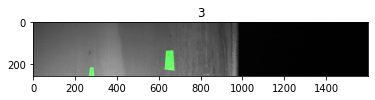

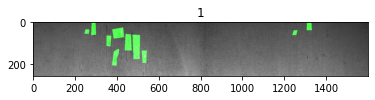

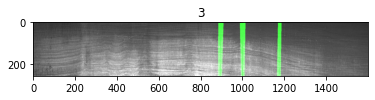

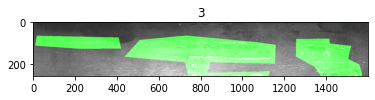

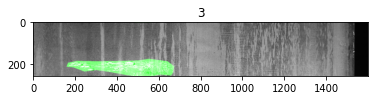

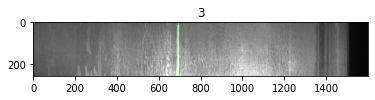

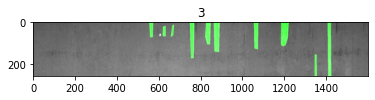

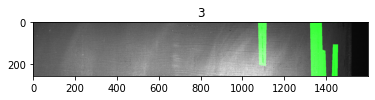

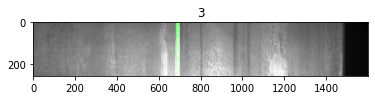

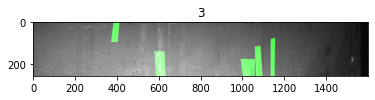

In [30]:
# viewing images along with their original  masks
for i in range(10, 20):

  # read the images using opencv and convert them to rgb format
  img = io.imread(os.path.join(train_img_dir,test_df.ImageId[i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Obtain mask for the image from rle
  mask = rle2mask(test_df.EncodedPixels[i],img.shape[0],img.shape[1])

  img[mask == 1,1] = 255
  plt.figure()
  plt.title(test_df.ClassId[i])
  plt.imshow(img)

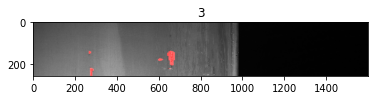

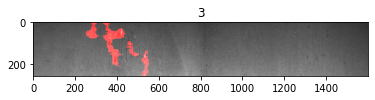

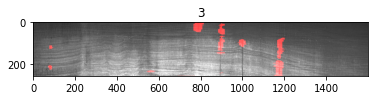

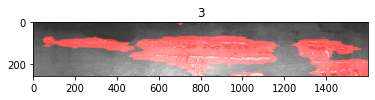

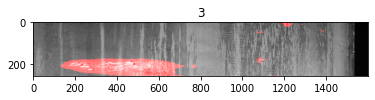

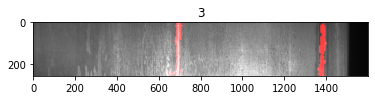

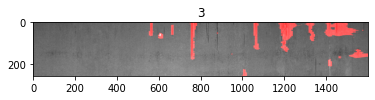

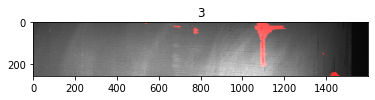

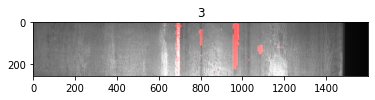

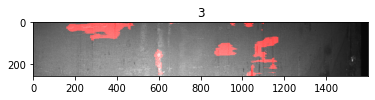

In [31]:
# visualizing the results (model predictions)

directory = "train_images"

for i in range(10, 20):

  # read the images using opencv and convert to rgb format
  img = io.imread(os.path.join(directory,df_pred.ImageId[i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # get the mask for the image from rle
  mask = rle2mask(df_pred.EncodedPixels[i],img.shape[0],img.shape[1])
  
  img[mask == 1,0] = 255
  plt.figure()
  plt.title(df_pred.ClassId[i])
  plt.imshow(img)